# Car Vs Ambulance classification using ensemble CNN


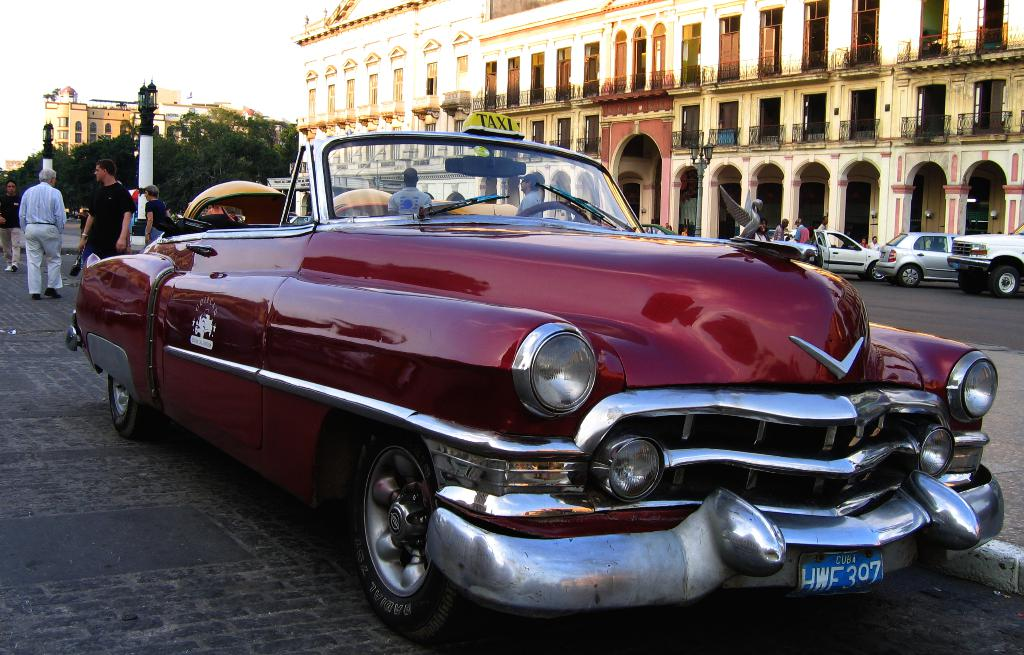

## 1. **Introduction**
Here’s a bullet-point description of the dataset:

### About Dataset
**Source of the Dataset** : [image-classification-and-yolo-dataset](https://www.kaggle.com/datasets/amansingh0000000/image-classification-and-yolo-dataset/data) \
**Classes**: Contains images of two primary classes: cars and ambulances. \
**Diversity**: Images include various angles, lighting conditions, and backgrounds.  \
**Labeling**: Each image is labeled for accurate classification and detection. \

**Applications**: \
**Image classification**: Identifying whether an image contains a car or an ambulance. \
**Object detection**: Locating and recognizing cars and ambulances within images. \
**Use Cases**: Ideal for projects such as traffic monitoring, emergency vehicle detection, and automated vehicle recognition systems. \
               Train file is for different types of Cars and Ambulances images. \
               Label file for the labels,which show the labels regarding about the images. 


## Planning
* Dataset also contain coordinates for each object in the image
* First I will try to work on only Object classification problem
* Then i will try to use those coordinates and make this problem as an Object detection

## 2. Data Preparation

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import opendatasets as od
import random
import pathlib 
import os

tf.__version__

2024-09-19 05:29:17.812703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 05:29:17.824459: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 05:29:17.828022: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 05:29:17.838475: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.17.0'

In [2]:
tf.config.list_physical_devices('GPU')

I0000 00:00:1726723759.655497   11330 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726723759.663178   11330 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726723759.665019   11330 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def download_datasets_from_kaggle(dataset_url:str, dataset_dir:str)-> None:
    # Dowload the dataset
    data_dir = pathlib.Path(dataset_dir)
    data_dir.mkdir(exist_ok=True)
    if os.path.isdir(dataset_dir):
        od.download(dataset_url, data_dir=data_dir)
    

In [4]:
# Dowload the dataset
dataset_url = 'https://www.kaggle.com/datasets/amansingh0000000/image-classification-and-yolo-dataset/data'
# Look into the data directory
dataset_dir = '../dataset'
download_datasets_from_kaggle(dataset_url=dataset_url, dataset_dir=dataset_dir)

Skipping, found downloaded files in "../dataset/image-classification-and-yolo-dataset" (use force=True to force download)


I. Quick look at the downloaded data

In [5]:
dataset_dir= dataset_dir + '/image-classification-and-yolo-dataset' + '/Ambulance_Car'
dataset_dir

'../dataset/image-classification-and-yolo-dataset/Ambulance_Car'

In [6]:
train_dir = dataset_dir + '/Train'
lables_dir = dataset_dir + '/Label'

In [7]:
len(os.listdir(train_dir)), len(os.listdir(lables_dir))

(1138, 1138)

II. Load data into the memory

In [8]:
import glob
import cv2

images = []
labels = []
IMAGE_SIZE = 224
for _image_path in glob.glob(train_dir+"/*.jpg"):
    _img = cv2.imread(filename=_image_path)
    _img = cv2.resize(_img, (IMAGE_SIZE,IMAGE_SIZE))
    # print(_image_path)
    file_name_without_ext = _image_path.split('/')[-1].split('.')[0]
    label_file = f'{lables_dir}/{file_name_without_ext}.txt'
    # print(label_file)
    with open(label_file, 'r') as _labels:
        for line in _labels.readlines():
            _label, x_min, y_min, x_max, y_max = line.split()
            labels.append(_label)
            images.append(_img)
            # print(_label)
              

In [9]:
len(images), len(labels)

(2784, 2784)

In [10]:
def plot_images_with_label(images, labels):
    random_nums = random.sample(range(0, len(images)), 6)
    for idx, rand_num in enumerate(random_nums):
        plt.subplot(3, 3, idx+1)
        plt.imshow(images[rand_num])
        plt.title(labels[rand_num])
        plt.axis('off')
    plt.show() 

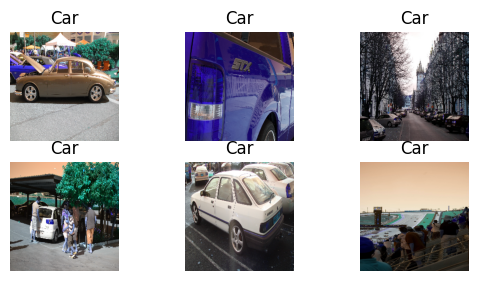

In [11]:
plot_images_with_label(images, labels)

### Data transforms (normalization & data augmentation)

Dataset split for training and testing

In [12]:
import numpy as np
images_arr = np.array(images)
labels_arr = np.array(labels)
images_arr.shape, labels_arr.shape

((2784, 224, 224, 3), (2784,))

In [13]:
images_arr[0]

array([[[ 84,  99,  98],
        [ 83,  95,  99],
        [ 87, 106, 103],
        ...,
        [ 55,  43,  33],
        [ 50,  37,  29],
        [ 48,  35,  27]],

       [[ 81, 102, 107],
        [ 93, 104, 113],
        [ 87,  99,  99],
        ...,
        [ 50,  38,  29],
        [ 49,  36,  28],
        [ 50,  37,  29]],

       [[ 88, 100, 100],
        [ 92, 106, 108],
        [ 90,  97, 100],
        ...,
        [ 50,  38,  32],
        [ 56,  40,  33],
        [ 54,  39,  33]],

       ...,

       [[ 38,  37,  33],
        [ 21,  20,  16],
        [  5,   5,   5],
        ...,
        [ 42,  40,  37],
        [ 46,  45,  41],
        [ 40,  40,  35]],

       [[  2,   1,   1],
        [ 15,  17,  14],
        [  9,   7,   7],
        ...,
        [ 40,  39,  36],
        [ 43,  43,  39],
        [ 42,  42,  36]],

       [[ 55,  49,  43],
        [ 30,  29,  28],
        [ 12,  12,  12],
        ...,
        [ 43,  43,  37],
        [ 39,  37,  36],
        [ 44,  44,  38]]

In [14]:
# Normalizing images
images_arr = images_arr/255.
images_arr[0]

array([[[0.32941176, 0.38823529, 0.38431373],
        [0.3254902 , 0.37254902, 0.38823529],
        [0.34117647, 0.41568627, 0.40392157],
        ...,
        [0.21568627, 0.16862745, 0.12941176],
        [0.19607843, 0.14509804, 0.11372549],
        [0.18823529, 0.1372549 , 0.10588235]],

       [[0.31764706, 0.4       , 0.41960784],
        [0.36470588, 0.40784314, 0.44313725],
        [0.34117647, 0.38823529, 0.38823529],
        ...,
        [0.19607843, 0.14901961, 0.11372549],
        [0.19215686, 0.14117647, 0.10980392],
        [0.19607843, 0.14509804, 0.11372549]],

       [[0.34509804, 0.39215686, 0.39215686],
        [0.36078431, 0.41568627, 0.42352941],
        [0.35294118, 0.38039216, 0.39215686],
        ...,
        [0.19607843, 0.14901961, 0.1254902 ],
        [0.21960784, 0.15686275, 0.12941176],
        [0.21176471, 0.15294118, 0.12941176]],

       ...,

       [[0.14901961, 0.14509804, 0.12941176],
        [0.08235294, 0.07843137, 0.0627451 ],
        [0.01960784, 0

In [15]:
labels_arr[:5]

array(['Car', 'Car', 'Car', 'Car', 'Car'], dtype='<U9')

In [16]:

label_names = ['car', 'ambulance']

In [17]:
from sklearn.calibration import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels_arr)
encoded_labels[:5], label_encoder.classes_

(array([1, 1, 1, 1, 1]), array(['Ambulance', 'Car'], dtype='<U9'))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(images_arr, encoded_labels, test_size=0.2, shuffle=True, random_state=42) 
len(X_train), len(X_test)

(2227, 557)

In [19]:
#  Convert the split data into TensorFlow datasets
BATCH_SIZE=32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

# Prefetch to optimize performance
train_dataset_prefetch = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset_prefech = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

I0000 00:00:1726723765.485012   11330 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726723765.489564   11330 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726723765.491703   11330 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726723765.606037   11330 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [20]:
for elem in train_dataset_prefetch.take(1):
    print(elem)
    break

2024-09-19 05:29:30.948598: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2681806848 exceeds 10% of free system memory.


(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float64, numpy=
array([[[[0.2       , 0.25882353, 0.27058824],
         [0.25490196, 0.29411765, 0.27058824],
         [0.27843137, 0.29019608, 0.23529412],
         ...,
         [0.98823529, 0.96078431, 0.89411765],
         [0.99215686, 0.99215686, 0.91372549],
         [0.98431373, 0.99215686, 0.94509804]],

        [[0.21568627, 0.25098039, 0.21568627],
         [0.22352941, 0.25098039, 0.22352941],
         [0.1372549 , 0.16862745, 0.12941176],
         ...,
         [0.99607843, 0.97254902, 0.89803922],
         [0.98823529, 0.98039216, 0.90588235],
         [0.98431373, 0.98823529, 0.9254902 ]],

        [[0.06666667, 0.08627451, 0.04313725],
         [0.08235294, 0.09411765, 0.05490196],
         [0.0627451 , 0.07843137, 0.03137255],
         ...,
         [0.98431373, 0.96078431, 0.88627451],
         [0.99607843, 0.99607843, 0.92156863],
         [0.99215686, 0.99215686, 0.92941176]],

        ...,

        [[0.29411765, 0.29411765

## Model 1 - MiniVGGNet

### MiniVGGNet Build

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Input

class MiniVGGNet:
    @staticmethod
    def build(width:int, height:int, depth:int):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself

        inputShape = (height, width, depth)
        chanDim = -1

        return Sequential([
            Input(shape=inputShape),
            # first CONV => RELU => CONV => RELU => POOL layer set
            Conv2D(32, (3, 3), padding="same", activation='relu'),
            BatchNormalization(axis=chanDim),

            Conv2D(32, (3, 3), padding="same", activation='relu'),
            BatchNormalization(axis=chanDim),

            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),

            # second CONV => RELU => CONV => RELU => POOL layer set
            Conv2D(64, (3, 3), padding="same", activation='relu'),
            BatchNormalization(axis=chanDim),

            Conv2D(64, (3, 3), padding="same", activation='relu'),
            BatchNormalization(axis=chanDim),

            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),

            # first (and only) set of FC => RELU layers
            Flatten(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),

            # softmax classifier
            Dense(1, activation='sigmoid')

        ])

In [28]:
opt = SGD(learning_rate=1e-2, weight_decay=0.01 / 40, momentum=0.9, nesterov=True)
mini_vggnet_model = MiniVGGNet.build(width=IMAGE_SIZE, height=IMAGE_SIZE, depth=3)
mini_vggnet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,829,857 (392.26 MB)

 Trainable params: 102,828,449 (392.26 MB)

 Non-trainable params: 1,408 (5.50 KB)

### MiniVGGNet Train

In [29]:

mini_vggnet_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy", "precision", "recall"])

# train the network
mini_vggnet_history = mini_vggnet_model.fit(train_dataset_prefetch,
              validation_data=val_dataset_prefech,
              batch_size=BATCH_SIZE,
              epochs=20,
              verbose=1)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.6990 - loss: 0.7422 - val_accuracy: 0.8133 - val_loss: 0.5306
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8569 - loss: 0.3713 - val_accuracy: 0.8923 - val_loss: 0.3760
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8808 - loss: 0.3239 - val_accuracy: 0.8743 - val_loss: 0.4273
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9115 - loss: 0.2672 - val_accuracy: 0.9120 - val_loss: 0.3036
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9438 - loss: 0.1802 - val_accuracy: 0.8797 - val_loss: 0.5370
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9449 - loss: 0.1718 - val_accuracy: 0.9336 - val_loss: 0.2752
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9530 - loss: 0.1361 - val_accuracy: 0.9013 - val_loss: 0.4456
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9647 - loss: 0.1216 - val_accuracy: 0.9282 - v

In [30]:
tf.keras.backend.clear_session()

### MiniVGGNet Results Plot

In [81]:
# Plot accuracies
def plot_accuracies(history):
    train_accuracy = history.history['accuracy'] 
    val_accuracy = history.history['val_accuracy'] 
    plt.plot(np.arange(0, 20), train_accuracy, '-x', label='train_accuracy')
    plt.plot(np.arange(0, 20), val_accuracy, '-x', label='val_accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train Accuracy', 'Validation Accuracy'])
    plt.ylabel('train_accuracy/val_accuracy')
    plt.title('Accuracy vs. No. of epochs')

def plot_losses(history):
    train_losses = history.history['loss']
    val_losses =history.history['val_loss']
    plt.plot(np.arange(0, 20),train_losses, '-bx', label='train_losses')
    plt.plot(np.arange(0, 20),val_losses, '-rx', label='val_losses')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Train Loss', 'Validation Loss'])
    plt.title('Loss vs. No. of epochs')

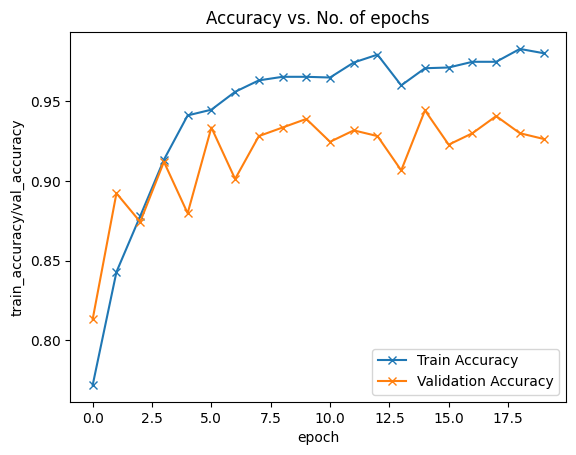

In [82]:
plot_accuracies(mini_vggnet_history)

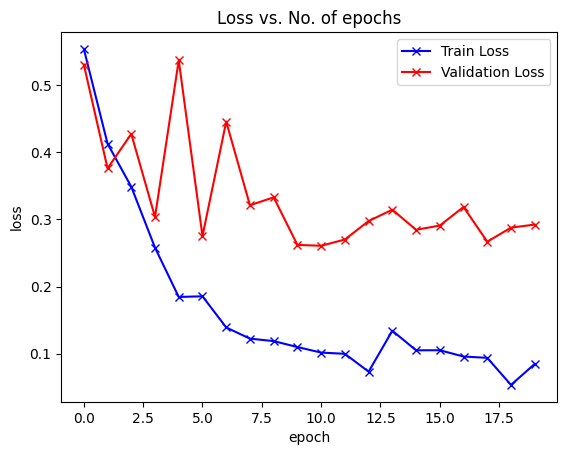

In [78]:
plot_losses(mini_vggnet_history)

## Model 2 - LeNet

### LeNet Build

In [91]:
class LeNet:
    @staticmethod
    def build(width:int, height:int, depth:int):
        inputShape = (height, width, depth)
        
        # initialize the model
        return Sequential([
            Input(shape=inputShape),
            # first set of CONV => RELU => POOL layers
            Conv2D(20, (5, 5), padding='same',  activation='relu',input_shape=inputShape),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

            # second set of CONV => RELU => POOL layers
            Conv2D(50, (5, 5), padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

            Flatten(),
            Dense(500, activation='relu'),
            Dense(1, activation='sigmoid'),
        ])

In [92]:
opt = SGD(learning_rate=1e-2, weight_decay=0.01 / 40, momentum=0.9, nesterov=True)
Lenet_model = LeNet.build(width=IMAGE_SIZE, height=IMAGE_SIZE, depth=3)
Lenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 20)   │         1,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 20)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 50)   │        25,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │    78,400,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,427,571 (299.18 MB)

 Trainable params: 78,427,571 (299.18 MB)

 Non-trainable params: 0 (0.00 B)

### LeNet Train

In [93]:

Lenet_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy", "precision", "recall"])

# train the network
Lenet_model_history = Lenet_model.fit(train_dataset_prefetch,
              validation_data=val_dataset_prefech,
              batch_size=BATCH_SIZE,
              epochs=20,
              verbose=1)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.7883 - loss: 0.5381 - precision: 0.8209 - recall: 0.9330 - val_accuracy: 0.8618 - val_loss: 0.4911 - val_precision: 0.8618 - val_recall: 1.0000
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8460 - loss: 0.3943 - precision: 0.8514 - recall: 0.9902 - val_accuracy: 0.8833 - val_loss: 0.2859 - val_precision: 0.8952 - val_recall: 0.9792
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8787 - loss: 0.2981 - precision: 0.8959 - recall: 0.9675 - val_accuracy: 0.9031 - val_loss: 0.2862 - val_precision: 0.9128 - val_recall: 0.9812
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9109 - loss: 0.2369 - precision: 0.9201 - recall: 0.9778 - val_accuracy: 0.7612 - val_loss: 0.4904 - val_precision: 0.9753 - val_recall: 0.7417
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9419 - loss: 0.1688 - precision: 0.9525 - recall: 0.9799 - val_accuracy: 0.9300 - val_loss: 0.2317 

### LeNet Result Plot